# General Practitioners in Ile de France

In [1]:
from pynsee.sirene import get_dimension_list, search_sirene
from pynsee.metadata import get_activity_list
from pynsee.geodata import get_geodata_list, get_geodata

import difflib
import geopandas as gpd
import numpy
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import descartes
import re
from shapely.geometry import Polygon, MultiPolygon
from matplotlib.offsetbox import AnchoredText

In [2]:
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [3]:
get_dimension_list().to_csv("sirene_dimensions.csv")

!!! Existing environment variables used, instead of locally saved credentials !!!


1 - Getting data: 100%|██████████| 1/1 [00:00<00:00, 115.90it/s]


Data saved: /home/jovyan/.cache/pynsee/pynsee/76f10aaaadf5a625061805b71f0bf0db


Getting legal entities: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

Data saved: /home/jovyan/.cache/pynsee/pynsee/5962dad803c0e24f17b739bf3a6080cc

!!! This function may return personal data, please check and
 comply with the legal framework relating to personal data protection !!!


In [4]:
# get activity list
naf5 = get_activity_list('NAF5')
naf5.to_csv("naf.csv")
naf5[naf5["NAF5"].str.contains("^86.2")]

,A10,A129,A17,A21,A38,A5,A64,A88,NAF1,NAF2,NAF3,NAF4,NAF5,TITLE_NAF5_40CH_FR,TITLE_NAF5_65CH_FR,TITLE_NAF5_FR
664,OQ,Q86Z,OQ,Q,QA,OQ,QA0,86,Q,86,86.2,86.21,86.21Z,Activité des médecins généralistes,Activité des médecins généralistes,Activité des médecins généralistes
665,OQ,Q86Z,OQ,Q,QA,OQ,QA0,86,Q,86,86.2,86.22,86.22A,Act. radiodiagnostic et de radiothérapie,Activités de radiodiagnostic et de radiothérapie,Activités de radiodiagnostic et de radiothérapie
666,OQ,Q86Z,OQ,Q,QA,OQ,QA0,86,Q,86,86.2,86.22,86.22B,Activités chirurgicales,Activités chirurgicales,Activités chirurgicales
667,OQ,Q86Z,OQ,Q,QA,OQ,QA0,86,Q,86,86.2,86.22,86.22C,Autre activité des médecins spécialistes,Autres activités des médecins spécialistes,Autres activités des médecins spécialistes
668,OQ,Q86Z,OQ,Q,QA,OQ,QA0,86,Q,86,86.2,86.23,86.23Z,Pratique dentaire,Pratique dentaire,Pratique dentaire


In [5]:
# departements list of ile de france
list_dep = ["91", "92", "93", "75", "77", "78", "95", "94"]
string_dep = "|".join([dep + "*" for dep in list_dep])
string_dep

'91*|92*|93*|75*|77*|78*|95*|94*'

In [6]:
# search data on doctors

doctors = search_sirene(variable = ["activitePrincipaleEtablissement", "codePostalEtablissement"],
                        pattern = ['86.21Z*', string_dep],
                        number = 100000)
 # '86.21Z' médecin généraliste

doctors = doctors[doctors["activitePrincipaleEtablissement"].str.contains("^86.21Z")].reset_index(drop=True)

40/100 - Getting data: 100%|██████████| 685/685 [00:02<00:00, 264.54it/s]


41/100 - No more data found
42/100 - No more data found
Data saved: /home/jovyan/.cache/pynsee/pynsee/e5b224414766f6cb9f53d1aa6f21b707


Getting legal entities:  35%|███▌      | 17/48 [00:03<00:05,  5.41it/s]


API query number limit reached - function might be slowed down


Getting legal entities: 100%|██████████| 48/48 [01:08<00:00,  1.43s/it]


Data saved: /home/jovyan/.cache/pynsee/pynsee/5ec4e1172b2f212596fe8b2847a051c8


In [7]:
doctors.to_csv('doc.csv')

In [8]:
# filter
list_pattern = ["RADIOLOGIE", "IMAGERIE", "GYNECO", "DENTAIRE", "ANESTHES", 'P.M.I', 'INFANTILE', 'CARDIOLOG',
                "MAXILLO", "HOSPITALIER", "OPHTALMO", "DERMATOLOG", 'PLANIFICATION', 'MAIRIE', 'THORACIQUE',
                "TOMODENSITOM", "URGENCE", "NEPHROLOG", "PRAXEA", 'VACCINATION', 'SCOLAIRE', 'CANCER', 'STOMATOLO',
                "URODYNAMIQ", "CARDIORIS", "CHIRPLASTIQUE", "NINAMAX", "CICOF", 'MATERNELLE', 'DIALYSE',
                'RADIOTHERAPIE', 'RHUMATOLOG', 'DENTISTE', 'ECHOGRAPH', 'PATHOLOG', 'CHIRURGIE', 'ESTHETIQ',
                'CYTOLOG', 'ORTHOPED']

pattern = r"|".join(list_pattern)

In [9]:
# clean up the data not related to general practitioners but to other health activities
doctors = doctors[~doctors["denominationUniteLegale"].str.contains(pattern, regex=True, na=False)].reset_index(drop=True)
doctors = doctors[~doctors["enseigne1Etablissement"].str.contains(pattern, regex=True, na=False)].reset_index(drop=True)

# exclude association and administration
doctors = doctors[~doctors["categorieJuridiqueUniteLegale"].isin(["9220", "7220"])].reset_index(drop=True)
doctors = doctors.sort_values(["categorieJuridiqueUniteLegale"])

doctors.to_csv("doctors.csv")
list_denomination_uniteLegale = doctors.denominationUniteLegale.unique()

In [10]:
# get geographical data list
geodata_list = get_geodata_list()

# get communes geographical limits
com = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:commune')

# get arrondissement (subdivision of departement) geographical limits
arr = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:arrondissement')


Data saved : /home/jovyan/.cache/pynsee/pynsee/2ac583be54e866b2b1b30fb0113c1fd0
Previously saved data has been used:
/home/jovyan/.cache/pynsee/pynsee/a4f589755961ab3aa6bdff99605334d1
Set update=True to get the most up-to-date data
Data saved: /home/jovyan/.cache/pynsee/pynsee/1b27559c061e4bdaa0bd2966f4605287


In [11]:
# get arrondissement municipal geographical limits
arrmun = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:arrondissement_municipal')
arrmun = arrmun[arrmun.insee_com.str.contains('^75')].reset_index(drop=True)
arrmun["nom_m"] = arrmun["nom_m"].apply(lambda x: re.sub(r"ER|E", "", re.sub(" ARRONDISSEMENT", "", x)))
arrmun = arrmun.rename(columns={"geometry" : "geometry2",
                                "population" : "population2",
                               "nom_m" : "nom_m2"})
arrmun = arrmun[["nom_m2", "geometry2", "population2"]]

Data saved: /home/jovyan/.cache/pynsee/pynsee/94d0586636b45c9d8cdd466da4a3f3b8


In [12]:
def _replace_nan(x, y):
    if (x is None) or (numpy.isnan(x)):
        return y
    else:
        return x

In [13]:
doctors

,siren,nic,siret,dateDebut,dateCreationEtablissement,dateCreationUniteLegale,dateFin,denominationUniteLegale,nomUniteLegale,prenomUsuelUniteLegale,...,codePaysEtrangerEtablissement,libellePaysEtrangerEtablissement,complementAdresse2Etablissement,indiceRepetition2Etablissement,libelleCommuneEtranger2Etablissement,distributionSpeciale2Etablissement,codeCedex2Etablissement,libelleCedex2Etablissement,codePaysEtranger2Etablissement,libellePaysEtranger2Etablissement
15065,950575050,00022,95057505000022,2008-01-01,2000-10-01,1989-07-10,None,None,SANDANA,ANTHONY,...,None,None,None,None,None,None,None,None,None,None
9044,481524726,00025,48152472600025,2015-02-01,2013-01-07,2004-12-09,None,None,LE FUR,SOPHIE,...,None,None,None,None,None,None,None,None,None,None
9045,481569960,00059,48156996000059,2014-01-01,2014-01-01,2005-02-01,None,None,MILGRAM COCHEREAU,SANDRINE,...,None,None,None,None,None,None,None,None,None,None
9046,481583995,00040,48158399500040,2017-05-01,2017-05-01,2005-01-01,None,None,KAZI-AOUL,NADIA,...,None,None,None,None,None,None,None,None,None,None
9049,481595957,00038,48159595700038,2021-04-06,2020-04-01,2004-10-20,None,None,THILL,SVEN,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6925,419443080,00017,41944308000017,2008-01-01,1978-07-06,1978-07-06,None,CENTRE SOINS FRANCISCAINES NOTRE DAME,None,None,...,None,None,None,None,None,None,None,None,None,None
10961,775663883,00020,77566388300020,2008-01-01,1900-01-01,1900-01-01,None,INSTITUT ARTHUR VERNES,None,None,...,None,None,None,None,None,None,None,None,None,None
10976,775683006,00362,77568300600362,2017-06-21,2017-06-21,1900-01-01,None,FONDATION SANTE DES ETUDIANTS DE FRANCE,None,None,...,None,None,None,None,None,None,None,None,None,None
407,313711038,00015,31371103800015,2008-01-01,1978-01-01,1978-01-01,None,FONDATION HAHNEMANN,None,None,...,None,None,None,None,None,None,None,None,None,None


In [14]:
# count general practioners by commun
hdLegalStatus = doctors.groupby(['categorieJuridiqueUniteLegale'], dropna=True)['effectifsMinEtablissement'].agg(['mean', "count"])
   
hdLegalStatus["meanHeadcountLegalStatus"] = hdLegalStatus["mean"].apply(lambda x: _replace_nan(x, 1))

hdLegalStatus["categorieJuridiqueUniteLegale"] = hdLegalStatus.index
hdLegalStatus.loc[hdLegalStatus["categorieJuridiqueUniteLegale"] == "1000", "meanHeadcountLegalStatus"] = 1
hdLegalStatus = hdLegalStatus.reset_index(drop=True)

doctors = doctors.merge(hdLegalStatus, how = "left", on = "categorieJuridiqueUniteLegale").reset_index(drop=True)

for r in doctors.index:
    hdMin = doctors.loc[r, "effectifsMinEtablissement"]
    if (hdMin is None) or (numpy.isnan(hdMin)):
        doctors.loc[r, "headcount"] = doctors.loc[r, "meanHeadcountLegalStatus"]
    else:
        doctors.loc[r, "headcount"] = hdMin

In [15]:
# duplicates cleaning
# normalization to avoid double counting
doctors["headcountFinal"] = doctors["headcount"] / doctors.groupby("siren", dropna=True)["headcount"].transform("sum")

#visual check duplicates
dupDoctors = doctors[doctors["siren"].duplicated(keep=False)].reset_index(drop=True)
dupDoctors.to_csv("dupDoctors.csv")

list_adress_var = ["numeroVoieEtablissement", "typeVoieEtablissementLibelle", 
                   "libelleVoieEtablissement", "codePostalEtablissement", "libelleCommuneEtablissement"]

addressDupDoctors = doctors[doctors[list_adress_var].duplicated(keep=False)].reset_index(drop=True)
addressDupDoctors = addressDupDoctors.sort_values(list_adress_var)
addressDupDoctors.to_csv("addressDupDoctors.csv")

In [16]:
doctors.sort_values(["libelleCommuneEtablissement"]).to_csv("doctorSortedCom.csv")

In [17]:
# count general practioners by commun

doctorsCom = doctors.groupby(['libelleCommuneEtablissement', 'codePostalEtablissement'])['headcountFinal'].agg(['sum'])
doctorsCom = doctorsCom.rename(columns = {"sum" : "headcount"})
doctorsCom

,,headcount
libelleCommuneEtablissement,codePostalEtablissement,
ABLIS,78660,3.00000
ABLON-SUR-SEINE,94480,2.50000
ACHERES,78260,12.00000
ACHERES-LA-FORET,77760,0.50000
ALFORTVILLE,94140,30.25000
...,...,...
VOISINS-LE-BRETONNEUX,78960,11.00000
VOULX,77940,4.00000
VULAINES-SUR-SEINE,77870,4.00000


In [18]:
doctorsCom["libelleCommuneEtablissement"] = doctorsCom.index.get_level_values("libelleCommuneEtablissement")
doctorsCom["codePostalEtablissement"] = doctorsCom.index.get_level_values("codePostalEtablissement")
doctorsCom = doctorsCom.reset_index(drop=True)

In [19]:
import os, sys 

communes = get_geo_list("communes")

def _find_commune_identifier(com, dep, communes=communes):
    
    try:
        list_com = [c.upper() for c in communes.TITLE.to_list()]    
        communes["TITLE"] = list_com    
        communes = communes[communes["CODE_DEP"] == dep].reset_index(drop=True)

        match = difflib.get_close_matches(com.upper(), list_com)[0]

        cog = communes[communes["TITLE"] == match].reset_index(drop=True)
        cog = cog.loc[0, "CODE"]
    except:
        cog = None
    
    return cog      
  
for r in doctorsCom.index:
    dep = doctorsCom.loc[r, "codePostalEtablissement"][:2]
    comName = doctorsCom.loc[r, "libelleCommuneEtablissement"]
    doctorsCom.loc[r, "insee_com"] = _find_commune_identifier(comName, dep)

Getting departements: 100%|██████████| 101/101 [00:00<00:00, 3172.62it/s]


In [20]:
comDep = com[com["insee_dep" ].isin(list_dep)].reset_index(drop=True)
doctorsCom2 = comDep.merge(doctorsCom, how = "left", on = "insee_com")
doctorsCom2.to_csv("doctorsDep.csv")

In [21]:
doctorsCom2["headcount"] = doctorsCom2["headcount"].apply(lambda x: _replace_nan(x, 0))

doctorsCom3 = doctorsCom2.copy().groupby(["insee_arr"])[["population", "headcount"]].agg(["sum"])
doctorsCom3["ratio"] = 1000 * doctorsCom3["headcount"] / doctorsCom3["population"]
doctorsCom3["insee_arr"] = doctorsCom3.index
doctorsCom3 = doctorsCom3.reset_index(drop=True)

arrDep = arr[arr["insee_dep"].isin(list_dep)].reset_index(drop=True)
doctorsCom3 = doctorsCom3.merge(arrDep[["insee_arr", "geometry"]], how= "left", on = "insee_arr")
doctorsCom3 = doctorsCom3.rename(columns = {"('ratio','')" : "ratio"})
doctorsCom3.columns = ["insee_arr", "population", "headcount", "ratio", "insee_arr2", "geometry"]
doctorsCom3

/tmp/ipykernel_5664/502053976.py:9: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  doctorsCom3 = doctorsCom3.merge(arrDep[["insee_arr", "geometry"]], how= "left", on = "insee_arr")


,insee_arr,population,headcount,ratio,insee_arr2,geometry
0,1,47799570,6739.607517,0.140997,1,"(POLYGON ((263182.01671144 6243765.25756816, 2..."
1,1,47799570,6739.607517,0.140997,1,"(POLYGON ((322265.87345218 6287946.6228104, 32..."
2,1,47799570,6739.607517,0.140997,1,"(POLYGON ((169012.50312614 6271197.65027422, 1..."
3,1,47799570,6739.607517,0.140997,1,"(POLYGON ((219042.28287385 6194856.7107581, 21..."
4,1,47799570,6739.607517,0.140997,1,"(POLYGON ((253606.20819294 6243401.87012695, 2..."
5,1,47799570,6739.607517,0.140997,1,"(POLYGON ((268294.30642005 6260725.57658092, 2..."
6,1,47799570,6739.607517,0.140997,1,"(POLYGON ((274756.07552845 6234636.82506559, 2..."
7,1,47799570,6739.607517,0.140997,1,"(POLYGON ((248365.3624873 6283673.2844393, 248..."
8,2,3853233,3524.638373,0.914722,2,"(POLYGON ((281783.49491065 6202823.58483382, 2..."
9,2,3853233,3524.638373,0.914722,2,"(POLYGON ((189584.45269257 6240926.67520392, 1..."


In [22]:
doctorsCom2["headcount"] = doctorsCom2["headcount"].apply(lambda x: _replace_nan(x, 0))
doctorsCom2["ratio"] = 1000 * doctorsCom2["headcount"] / doctorsCom2["population"]
doctorsCom2.loc[doctorsCom2["nom_m"] == "CHEVANNES", "ratio"] = 2
doctorsCom2.sort_values(["ratio"], ascending=False)

,id,nom,nom_m,insee_com,statut,population,insee_can,insee_arr,insee_dep,insee_reg,siren_epci,geometry,bbox,crs,headcount,libelleCommuneEtablissement,codePostalEtablissement,ratio
355,COMMUNE_0000000009740130,Roinvilliers,ROINVILLIERS,91526,Commune simple,107,08,1,91,11,200017846,"(POLYGON ((250049.53501001 6161865.64613179, 2...","[245706.74420296, 6161543.54066951, 251246.133...",EPSG:3857,1.000000,ROINVILLIERS,91150,9.345794
670,COMMUNE_0000000009736500,Jossigny,JOSSIGNY,77237,Commune simple,656,22,5,77,11,247700594,"(POLYGON ((306391.53836197 6249591.98342643, 3...","[305343.01824851, 6242023.11272052, 310058.075...",EPSG:3857,6.062336,JOSSIGNY,77600,9.241366
1077,COMMUNE_0000000009734513,Villiers-le-Sec,VILLIERS-LE-SEC,95682,Commune simple,189,09,2,95,11,200073013,"(POLYGON ((266744.03698707 6289583.07241044, 2...","[263521.76530462, 6285635.06747645, 267739.656...",EPSG:3857,1.000000,VILLIERS-LE-SEC,95720,5.291005
733,COMMUNE_0000000009739715,Valence-en-Brie,VALENCE-EN-BRIE,77480,Commune simple,1048,14,2,77,11,200070779,"(POLYGON ((325845.24966123 6179547.29484033, 3...","[318270.89013511, 6177932.36299577, 325845.249...",EPSG:3857,5.000000,VALENCE-EN-BRIE,77830,4.770992
268,COMMUNE_0000000009734577,Blaru,BLARU,78068,Commune simple,894,02,1,78,11,200071074,"(POLYGON ((166307.85603507 6279327.89878185, 1...","[161001.38588736, 6278019.43157985, 169529.072...",EPSG:3857,4.000000,BLARU,78270,4.474273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,COMMUNE_0000000009736488,Tigeaux,TIGEAUX,77466,Commune simple,381,21,1,77,11,200090504,"(POLYGON ((324881.83850869 6246967.17542264, 3...","[320068.2014806, 6242326.61854266, 324881.8385...",EPSG:3857,0.000000,NaN,NaN,0.000000
490,COMMUNE_0000000009738850,Roinville,ROINVILLE,91525,Commune simple,1340,05,1,91,11,249100595,"(POLYGON ((228840.32628685 6198538.29761666, 2...","[226303.86599997, 6188268.86991145, 230862.449...",EPSG:3857,0.000000,NaN,NaN,0.000000
491,COMMUNE_0000000009738849,Sermaise,SERMAISE,91593,Commune simple,1610,05,1,91,11,249100595,"(POLYGON ((229420.24165063 6198757.93550878, 2...","[229420.24165063, 6191970.3170707, 236240.3273...",EPSG:3857,0.000000,NaN,NaN,0.000000
492,COMMUNE_0000000009737907,Bernay-Vilbert,BERNAY-VILBERT,77031,Commune simple,905,08,3,77,11,200072874,"(POLYGON ((328029.43976461 6221935.58743502, 3...","[322387.76305644, 6216079.78728779, 331124.469...",EPSG:3857,0.000000,NaN,NaN,0.000000


In [23]:
doctorsCom2 = doctorsCom2.reset_index(drop=True)

doctorsCom4 = doctorsCom2[doctorsCom2.columns].merge(arrmun, left_on ="libelleCommuneEtablissement", right_on="nom_m2", how="left")
for i in doctorsCom4.index:
    if type(doctorsCom4.loc[i, 'geometry2']) in [MultiPolygon, Polygon]:
        doctorsCom4.loc[i, 'geometry'] = doctorsCom4.loc[i, 'geometry2']
        doctorsCom4.loc[i, "ratio"] = 1000 * doctorsCom4.loc[i,"headcount"] / doctorsCom4.loc[i,"population2"]

del doctorsCom4["geometry2"]
doctorsCom2Map = gpd.GeoDataFrame(doctorsCom4)

In [24]:
doctorsCom2Map = gpd.GeoDataFrame(doctorsCom4)


In [25]:
# compute density ranges of GP
doctorsCom2Map.loc[doctorsCom2Map.ratio < 1, 'range'] = "< 0.2"
doctorsCom2Map.loc[doctorsCom2Map.ratio >= 5, 'range'] = "> 5"

density_ranges = [0.2, 0.6, 1, 1.5, 2, 2.5, 3, 3.5, 5]
list_ranges = []
list_ranges.append( "< 0.2")

for i in range(len(density_ranges)-1):
    min_range = density_ranges[i]
    max_range = density_ranges[i+1]
    range_string = "[{}, {}[".format(min_range, max_range)
    rows = (doctorsCom2Map.ratio >= min_range) & (doctorsCom2Map.ratio < max_range)
    doctorsCom2Map.loc[rows, 'range'] = range_string
    list_ranges.append(range_string)

list_ranges.append("> 5")

doctorsCom2Map['range2'] = doctorsCom2Map['range'].astype(CategoricalDtype(categories=list_ranges, ordered=True))

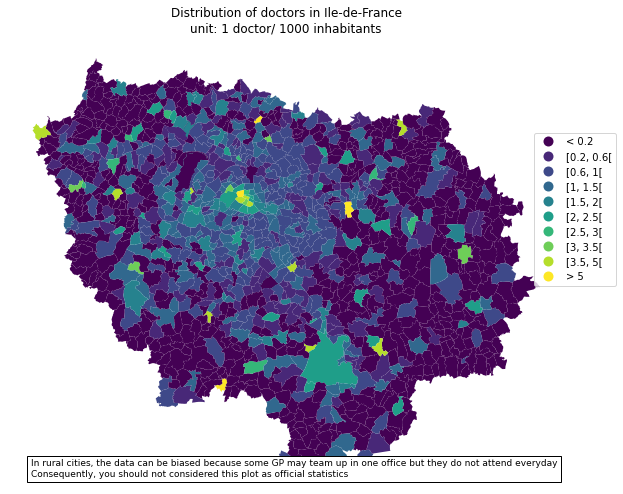

In [53]:
# make plot
txt = 'In rural cities, the data can be biased because some GP may team up in one office but they do not attend everyday'
txt += '\nConsequently, you should not considered this plot as official statistics'

fig, ax = plt.subplots(1,1,figsize=[10,10])
doctorsCom2Map.plot(column='range2', cmap=cm.viridis,
    legend=True, ax=ax, 
    legend_kwds={'bbox_to_anchor': (1.1, 0.8)})
ax.set_axis_off()
ax.set(title='Distribution of doctors in Ile-de-France\nunit: 1 doctor/ 1000 inhabitants')
at = AnchoredText(txt, prop=dict(size=9), frameon=True, loc=4)
ax.add_artist(at)
plt.show()